# Mortgage Rate Model

This is the first model being built using the model building framework

## Packages, Function Imports, and Keys

In [1]:
from fredapi import Fred
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import clear_output

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
fred = Fred(api_key='1e208e2d66ac6382c25f85524a5820cc')

## Data Intake

In [3]:
def download_fred_data_as_dataframe(series_code = str):
    '''Downloads and cleans FRED API call into dataframe.'''

    # Download the series using fredapi
    fred_series = fred.get_series(series_code)

    # Convert the Series into a DataFrame and move the index into a column
    df_raw = fred_series.reset_index()

    # Convert the series code to lowercase for the column name
    lowercase_series_code = series_code.lower()

    # Explicitly rename columns by position to avoid guessing the column name
    df_raw.columns = ["date", lowercase_series_code]

    # Convert date column to datetime
    df_raw['date'] = pd.to_datetime(df_raw['date'])

    return df_raw

In [4]:
# Intake mortgage rate time series
df_mortgage_rate_weekly = download_fred_data_as_dataframe('MORTGAGE30US')

print(df_mortgage_rate_weekly)

           date  mortgage30us
0    1971-04-02          7.33
1    1971-04-09          7.31
2    1971-04-16          7.31
3    1971-04-23          7.31
4    1971-04-30          7.29
...         ...           ...
2852 2025-11-26          6.23
2853 2025-12-04          6.19
2854 2025-12-11          6.22
2855 2025-12-18          6.21
2856 2025-12-24          6.18

[2857 rows x 2 columns]


In [5]:
# 10 Year Treasury Yield
df_ten_year_yield_daily = download_fred_data_as_dataframe('DGS10')

print(df_ten_year_yield_daily)

            date  dgs10
0     1962-01-02   4.06
1     1962-01-03   4.03
2     1962-01-04   3.99
3     1962-01-05   4.02
4     1962-01-08   4.03
...          ...    ...
16685 2025-12-16   4.15
16686 2025-12-17   4.16
16687 2025-12-18   4.12
16688 2025-12-19   4.16
16689 2025-12-22   4.17

[16690 rows x 2 columns]


In [6]:
# 2 Year Treasury Yield
df_two_year_yield_daily = download_fred_data_as_dataframe('DGS2')

print(df_two_year_yield_daily)

            date  dgs2
0     1976-06-01  7.26
1     1976-06-02  7.23
2     1976-06-03  7.22
3     1976-06-04  7.12
4     1976-06-07  7.09
...          ...   ...
12925 2025-12-16  3.48
12926 2025-12-17  3.49
12927 2025-12-18  3.46
12928 2025-12-19  3.48
12929 2025-12-22  3.44

[12930 rows x 2 columns]


In [7]:
# 10Y–2Y spread
df_ten_two_yield_spread_daily = download_fred_data_as_dataframe('T10Y2Y')

print(df_ten_two_yield_spread_daily)

            date  t10y2y
0     1976-06-01    0.68
1     1976-06-02    0.71
2     1976-06-03    0.70
3     1976-06-04    0.77
4     1976-06-07    0.79
...          ...     ...
12926 2025-12-17    0.67
12927 2025-12-18    0.66
12928 2025-12-19    0.68
12929 2025-12-22    0.73
12930 2025-12-23    0.70

[12931 rows x 2 columns]


In [8]:
# Effective Federal funds rate
df_federal_funds_rate_daily = download_fred_data_as_dataframe('DFF')

print(df_federal_funds_rate_daily)

            date   dff
0     1954-07-01  1.13
1     1954-07-02  1.25
2     1954-07-03  1.25
3     1954-07-04  1.25
4     1954-07-05  0.88
...          ...   ...
26103 2025-12-18  3.64
26104 2025-12-19  3.64
26105 2025-12-20  3.64
26106 2025-12-21  3.64
26107 2025-12-22  3.64

[26108 rows x 2 columns]


## Clean Data
Follow the formatting of FRED

## Create a dataframe with dates, then merge all data onto it

In [9]:
df_dates = pd.DataFrame({
    "date": pd.date_range(start="1900-01-01", end=pd.Timestamp.today(), freq="D")
})

## Merge

Merge all data into one big dataframe. We start using a dataframe that contains every date from 1900 to present. We then merge every dataframe containing data (target and explanatory) onto this clean date dataframe. The result is a clean dataframe where we can easily delete each row that does not contain data.

In [10]:
# List of all dataframes that contain data that will be in our model.
list_data_dfs = [
    df_mortgage_rate_weekly, 
    df_ten_year_yield_daily, 
    df_two_year_yield_daily, 
    df_ten_two_yield_spread_daily, 
    df_federal_funds_rate_daily]

In [11]:
def merge_dates_with_data(base_dates_dataframe, data_dataframe):
    # Merge a single data dataframe onto the base dates dataframe.
    # This function always returns a NEW dataframe and does not modify inputs.
    # An outer merge is used so no dates are lost.
    merged_dataframe = base_dates_dataframe.merge(
        data_dataframe,
        how="outer",
        on="date"
    )

    return merged_dataframe

In [12]:
# Start with the master date dataframe
df_all_data = df_dates.copy()

# Merge each dataframe one at a time (explicitly, no loop)
df_all_data = merge_dates_with_data(df_all_data, df_mortgage_rate_weekly)
df_all_data = merge_dates_with_data(df_all_data, df_ten_year_yield_daily)
df_all_data = merge_dates_with_data(df_all_data, df_two_year_yield_daily)
df_all_data = merge_dates_with_data(df_all_data, df_ten_two_yield_spread_daily)
df_all_data = merge_dates_with_data(df_all_data, df_federal_funds_rate_daily)

## Clean the DataFrame

To make this super simple on my self, we will assure datatypes for the whole dataframe, and standardize missing data.

In [13]:
df_all_data.columns

Index(['date', 'mortgage30us', 'dgs10', 'dgs2', 't10y2y', 'dff'], dtype='object')

In [14]:
# Rename Target column
target_column_name = 'mortgage30us'

df_all_data = df_all_data.rename(columns={target_column_name : 'target'})

In [15]:
# Drop rows where the target is not present.
df_all_data.dropna(subset=["target"], inplace=True)

In [16]:
# Assure that numeric cols are numeric and have standardized NaN values
numeric_cols = df_all_data.columns.difference(['date'])
df_all_data[numeric_cols] = (df_all_data[numeric_cols].apply(pd.to_numeric, errors='coerce').replace([np.inf, -np.inf], np.nan))

## Data Engineering and Transforming

12/21/2025 note: VIF is high between most variables. Highest correlation with dgs10. For sake of getting started, I will do a basic model of dgs10 on mortgage rate

In [17]:
# NOTE: After doing a review of VIF and correlation:
df_model_data = df_all_data.copy()

df_model_data = df_model_data[['date', 'target', 'dgs10']]

## EDA

### Correlation Matrix

This shows us how closesly correlated two variables are in our data. (> .50 or < -.5 represents higher correlation)

If two variables are correlated, it could represent a possible explanatory relationship.

- The most important variable to have high correlation is with the 'target'.

- If two variables THAT ARE NOT THE 'target' are highly correlated, we could have multicollinearity (bad), so we need to test VIF (below).

> If the correlation is positive, when one variable goes up, so does the other. Same vice versa, if the correlation is negative, when one variable goes up, the other goes down. Think about if this makes sense intuitively.

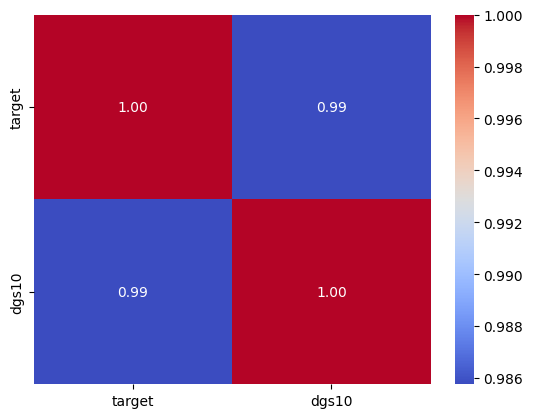

In [18]:
corr = df_model_data.drop(columns=["date"]).corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

### Correlation over time

The matrix above show us the correlation over all of history, but the relationship between variables can change over time. These graphs display how the correlation between the variables and the target changes over time, with a 95% confidence interval. A variable getting close to or crossing 0% could mean that the relationship is not strong, and should probably be removed from the model.

In [19]:
# --- hardcode these ---
df = df_model_data.copy()
WINDOW = 30
START_DATE = "2009-01-01"   # or None
END_DATE   = None # "2024-12-31"   # or None
# ----------------------

In [20]:
df = df.sort_values("date").set_index("date")
num = df.select_dtypes(include="number")

feature_cols = [c for c in num.columns if c != "target"]

# rolling correlation (index=date, columns=features)
corr = num[feature_cols].rolling(WINDOW).corr(num["target"])

# rolling sample size (pairwise non-NaN count per window)
n = pd.concat(
    {
        c: num[[c, "target"]].notna().all(axis=1).rolling(WINDOW).sum()
        for c in feature_cols
    },
    axis=1,
)

# hardcoded date filter
if START_DATE is not None:
    start_ts = pd.Timestamp(START_DATE)
    corr = corr.loc[corr.index >= start_ts]
    n = n.loc[corr.index]

if END_DATE is not None:
    end_ts = pd.Timestamp(END_DATE)
    corr = corr.loc[corr.index <= end_ts]
    n = n.loc[corr.index]

plt.style.use("seaborn-v0_8-whitegrid")
ZCRIT = 1.959963984540054  # ~95% CI

def corr_ci(r, n_):
    r = np.asarray(r, float)
    n_ = np.asarray(n_, float)

    lo = np.full_like(r, np.nan)
    hi = np.full_like(r, np.nan)

    ok = np.isfinite(r) & np.isfinite(n_) & (n_ >= 4) & (np.abs(r) < 1)
    if ok.any():
        z = np.arctanh(r[ok])
        se = 1.0 / np.sqrt(n_[ok] - 3.0)
        lo[ok] = np.tanh(z - ZCRIT * se)
        hi[ok] = np.tanh(z + ZCRIT * se)

    return lo, hi

def plot_corr(feature):
    clear_output(wait=True)

    r = corr[feature]
    nn = n[feature]
    lo, hi = corr_ci(r.values, nn.values)

    fig, ax = plt.subplots(figsize=(10, 3.2))
    ax.plot(r.index, r.values, color="#1f77b4", linewidth=2)
    ax.fill_between(r.index, lo, hi, color="#1f77b4", alpha=0.18, linewidth=0)

    ax.axhline(0, color="black", linewidth=1, alpha=0.6)
    ax.set_ylim(-1, 1)
    ax.set_title(f"{feature} vs target — rolling {WINDOW} corr (+ ~95% CI)", fontsize=12)
    ax.set_ylabel("Correlation")
    ax.set_xlabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

widgets.interact(
    plot_corr,
    feature=widgets.Dropdown(options=feature_cols)
)


interactive(children=(Dropdown(description='feature', options=('dgs10',), value='dgs10'), Output()), _dom_clas…

<function __main__.plot_corr(feature)>

### Variance Inflation Factor (VIF)

This tests for multicollinearity between columns. Multicollinearity is when two data sources are similar to, or the same, as one another. Multicollinearity is a problem for Linear and Polynomial Regression models. So if the model is only being solved using a basic regression, we should assure little to no multicollinearity.

Care about VIF if:
- You’re doing inference
- You care about coefficient signs/magnitudes
- You’re publishing / explaining results
- You’re using linear or logistic regression

Don’t care much if:
- You only care about prediction
- You’re using trees / boosting / RF
- You use regularization (ridge handles this)

> Values near 1 mean the variable is largely independent; values above ~5–10 indicate strong multicollinearity, and inf means exact redundancy that must be fixed. High VIF affects coefficient stability and interpretability, not predictive accuracy.

In [21]:
# NOTE: 12/21 - Skipping because we no longer have lots of variables.

# import numpy as np
# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# df_independents = df_model_data.apply(pd.to_numeric, errors="coerce")
# df_independents = df_independents.drop(columns=['date', 'target'])

# X = df_independents.dropna().to_numpy()

# vif = pd.Series(
#     [variance_inflation_factor(X, i) for i in range(X.shape[1])],
#     index=df_independents.columns,
#     name="VIF",
# ).sort_values(ascending=False)

# vif


### Modeling

In [22]:
df_model_data

,date,target,dgs10
26023,1971-04-02,7.33,5.60
26030,1971-04-09,7.31,NaN
26037,1971-04-16,7.31,5.82
26044,1971-04-23,7.31,6.01
26051,1971-04-30,7.29,6.08
...,...,...,...
45985,2025-11-26,6.23,4.00
45993,2025-12-04,6.19,4.11
46000,2025-12-11,6.22,4.14
46007,2025-12-18,6.21,4.12


In [35]:
# How many observations out should be predicted.
PREDICTION_HORIZON = 1
GROWTH_OR_LEVEL = 'growth' #'growth' or 'level'

df_model = df_model_data.copy()

if GROWTH_OR_LEVEL == 'level':
    # Shift the target and date by the prediction horizon
    df_model['target'] = df_model['target'].shift(PREDICTION_HORIZON)
    df_model['target_date'] = df_model['date'].shift(PREDICTION_HORIZON)
    df_model['feature_date'] = df_model['date']
    df_model.drop(columns=['date'])

    # Drop missing data due to the shift
    df_model.dropna(subset=['target'], inplace=True)

else:  # growth
    # Columns to convert to growth
    growth_cols = [
        c for c in df_model.columns
        if c not in ['target', 'date']
    ]

    # Convert features to growth
    df_model[growth_cols] = df_model[growth_cols].pct_change()

    # Convert target to growth separately
    df_model['target'] = df_model['target'].pct_change()

    # Shift the target and date by the prediction horizon
    df_model['target'] = df_model['target'].shift(PREDICTION_HORIZON)
    df_model['target_date'] = df_model['date'].shift(PREDICTION_HORIZON)
    df_model['feature_date'] = df_model['date']
    df_model.drop(columns=['date'])

    # Drop missing data due to the shift
    df_model.dropna(subset=['target'], inplace=True)


C:\Users\hrohw\AppData\Local\Temp\ipykernel_37324\2285007683.py:25: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_model[growth_cols] = df_model[growth_cols].pct_change()


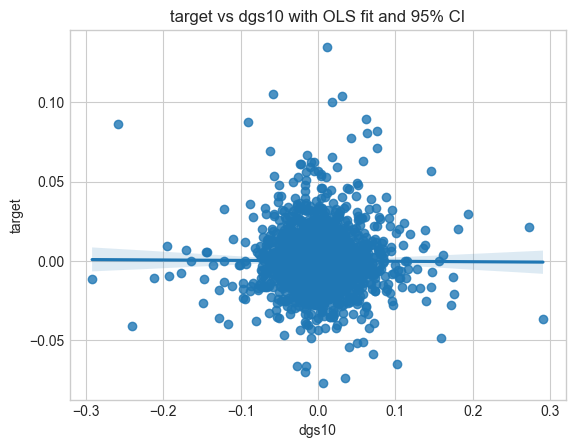

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

target_var = 'target'
comparison_var = 'dgs10'

df_plot = df_model[[comparison_var, target_var]].dropna()

plt.figure()
sns.regplot(
    data=df_plot,
    x=comparison_var,
    y=target_var,
    ci=95
)
plt.title("target vs dgs10 with OLS fit and 95% CI")
plt.show()


## Null Hypothesis

H0: There is a relationship between 10-year treasury rate and 30-year mortgage rate

HA: There is no relationship between 10-year treasury rate and 30-year mortgage rate

In [37]:
import statsmodels.formula.api as smf

model = smf.ols(formula='target ~ dgs10', data=df_model).fit()

# model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1170
Date:                Wed, 24 Dec 2025   Prob (F-statistic):              0.732
Time:                        12:58:23   Log-Likelihood:                 7859.6
No. Observations:                2855   AIC:                        -1.572e+04
Df Residuals:                    2853   BIC:                        -1.570e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.114e-05      0.000      0.212      0.8